In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras

## Data import

In [ ]:
extract_path= '/content/stack_overflow_dataset'
#os.mkdir(extract_path)
#!tar -xvf  'stack_overflow_16k.tar.gz' -C '/content/stack_overflow_dataset'

In [ ]:
train_dir = os.path.join(extract_path,'train')
train_dir

'/content/stack_overflow_dataset/train'

In [ ]:
test_dir = os.path.join(extract_path,'test')
test_dir

'/content/stack_overflow_dataset/test'

## Load data

In [ ]:
batch_size = 32
seed = 42 # to prevent training and validation overlapping

In [ ]:
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split = 0.2, 
    subset='training', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [ ]:
raw_validation_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split = 0.2, 
    subset='validation', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [ ]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir, 
    batch_size=batch_size)

Found 263 files belonging to 4 classes.


## Inspect Raw data

In [ ]:
print(f"There are {len(raw_train_ds.class_names)} in the dataset")

There are 4 in the dataset


In [ ]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [ ]:
for text_batch, label_batch in raw_train_ds.take(1): # take on batch
  for i in range(3): # print the 3 first samples in tha batch
    print("Question", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Question b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default const

## Data pre-processing and preparation (Tokenization)

In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [ ]:
max_features = 10000 # vocab length
sequence_length = 500

vectorize_layer = keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1) # add a dim as the first dim
  return vectorize_layer(text), label

In [ ]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text) # constaruct the vocab

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"unit testing of setters and getters teacher wanted us to do a comprehensive unit test. for me, this will be the first time that i use junit. i am confused about testing set and get methods. do you think should i test them? if the answer is yes; is this code enough for testing?..  public void testsetandget(){.    int a = 10;.    class firstclass = new class();.    firstclass.setvalue(10);.    int value = firstclass.getvalue();.    assert.asserttrue(""error"", value==a);.  }...in my code, i think if there is an error, we can\'t know that the error is deriving because of setter or getter."\n', shape=(), dtype=string)
Label java
Vectorized review (<tf.Tensor: shape=(1, 500), dtype=int64, numpy=
array([[1011,  773,    9, 2456,    8, 1863, 2362,  690, 1267,    4,   40,
           5,    1, 1011,  196,   12,   74,   13,   72,   33,    2,   98,
         105,   14,    3,   70, 9611,    3,   34,  888,  202,  773,  107,
           8,   41,  242,   40,   58,  291,   90,    3,  1

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_validation_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [ ]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  scissors
 313 --->  source
Vocabulary size: 10000


## Inspect final pre-processed data

In [ ]:
for text,label in train_ds:
  for i in range(batch_size):
    if not label[0].numpy() in [0,1,2,3]:
      print('label_encoding_error')

In [ ]:
for text,label in train_ds:
  for i in range(batch_size):
    if not (text[i].shape == (sequence_length,) and text[i].dtype == tf.int64):
      print("text vectorization error")
    

In [ ]:
for text,label in val_ds:
  for i in range(batch_size):
    if not label[0].numpy() in [0,1,2,3]:
      print('label_encoding_error')

In [ ]:
for text,label in val_ds:
  for i in range(batch_size):
    if not (text[i].shape == (sequence_length,) and text[i].dtype == tf.int64):
      print("text vectorization error")

## Build and train the model on GPUs

In [ ]:
mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
  embedding_dim = 16

  model = tf.keras.Sequential([
    keras.layers.Embedding(max_features + 1, embedding_dim),
    keras.layers.Dropout(0.2),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(4)])
  
  model.compile(loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer= 'adam',
                metrics= [keras.metrics.SparseCategoricalAccuracy()])
  history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 50
  )

  # Evaluate
  test_loss, test_accuracy = model.evaluate(test_ds)

  print("The model performance in the test set : ")
  print(f"Loss : {test_loss}")
  print(f"Accuracy : {test_accuracy}")

Epoch 1/50
200/200 [==============================] - 28s 127ms/step - loss: 1.3818 - sparse_categorical_accuracy: 0.3030 - val_loss: 1.3770 - val_sparse_categorical_accuracy: 0.3288
Epoch 2/50
200/200 [==============================] - 11s 54ms/step - loss: 1.3689 - sparse_categorical_accuracy: 0.3736 - val_loss: 1.3617 - val_sparse_categorical_accuracy: 0.4506
Epoch 3/50
200/200 [==============================] - 11s 54ms/step - loss: 1.3483 - sparse_categorical_accuracy: 0.4437 - val_loss: 1.3390 - val_sparse_categorical_accuracy: 0.5537
Epoch 4/50
200/200 [==============================] - 6s 32ms/step - loss: 1.3202 - sparse_categorical_accuracy: 0.5050 - val_loss: 1.3082 - val_sparse_categorical_accuracy: 0.5794
Epoch 5/50
200/200 [==============================] - 5s 25ms/step - loss: 1.2837 - sparse_categorical_accuracy: 0.5675 - val_loss: 1.2684 - val_sparse_categorical_accuracy: 0.6331
Epoch 6/50
200/200 [==============================] - 3s 16ms/step - loss: 1.2385 - sparse_

## Training visualization

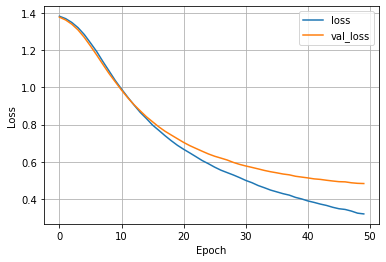

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
plot_loss(history)

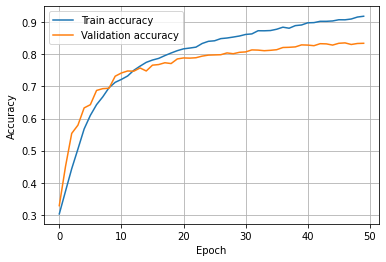

In [ ]:
def plot_accuracy(history):
  plt.plot(history.history['sparse_categorical_accuracy'], label='Train accuracy')
  plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation accuracy')
  #plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
plot_accuracy(history)

## Export the Model

In [ ]:

export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  keras.layers.Activation('sigmoid')
])

export_model.compile(loss= keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                optimizer= 'adam',
                metrics= [keras.metrics.SparseCategoricalAccuracy()])

predictions = export_model.predict(["Is there a setTimeout alternative in Javascript DOM?"]) # [number_smaple,numçclasses = 4]
class_id = np.argmax(predictions,axis=1)[0]
print(f"Your question is taged with a {raw_train_ds.class_names[class_id]} tag")


1/1 [==============================] - 0s 110ms/step
Your question is taged with a javascript tag
